# Wine Quality Prediction

Performing Data Science on Wine Quality Databases in the UCI repository. This is a supervised learning project since there is a training variable. Because the target variable is numeric we will evaluate this data against both linear and logistic regression algorithms. We will utilize regularization on our linear regression to prevent overfitting, and we will utilize ensembles to improve our logistic regression. Cross validation will allow us to tune our hyperparameters. 

Win condition: the wine quality comes in integer numbers. We will attempt to predict quality to a >90% accuracy after rounding our predictions.

Alternate win condition: The qualities range from 3-9, the mean is about 5.7-5.9 for both datasets, and the std is about .8-.9 for both. Any value 7 or above would be more than one STD above the mean for either dataset, we can define these as good wines and the others as bad and turn this into a binary classification problem. We will look for an AUROC score above .9.  

## 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_style('darkgrid')

In [129]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

In [45]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.exceptions import NotFittedError

In [118]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## I. Exploratory Analysis

In [3]:
ex_red = pd.read_csv('winequality-red.csv', sep=';')
ex_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
ex_white = pd.read_csv('winequality-white.csv', sep=';')
ex_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
ex_red.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
ex_white.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
print(ex_red.shape)
ex_red.drop_duplicates()
print(ex_red.shape)

(1599, 12)
(1599, 12)


In [10]:
print(ex_white.shape)
ex_red.drop_duplicates()
print(ex_white.shape)

(4898, 12)
(4898, 12)


In [13]:
ex_red.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [11]:
ex_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [12]:
ex_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [14]:
correlations_red = ex_red.corr()
correlations_white = ex_white.corr()

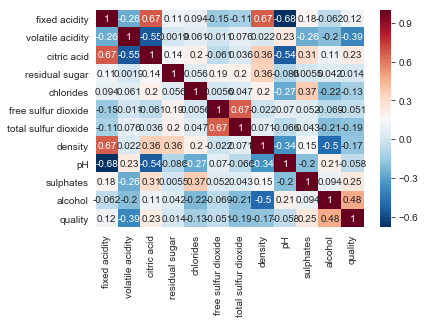

In [15]:
plt.figsize = (10,9)

sns.heatmap(correlations_red, annot=True, cmap='RdBu_r')

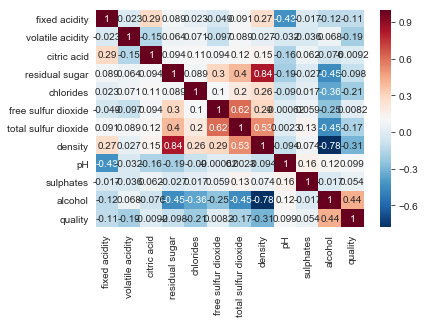

In [16]:
plt.figsize = (10,9)

sns.heatmap(correlations_white, annot=True, cmap='RdBu_r')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


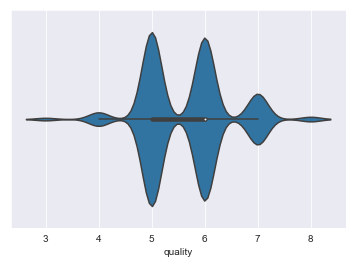

In [17]:
sns.violinplot(ex_red.quality)

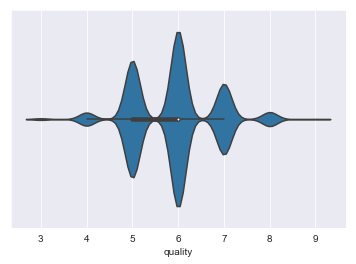

In [18]:
sns.violinplot(ex_white.quality)

## II. Generate Analytical Base Table

In [23]:
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

## III. Tune Models and Select Winning Algorithm

We will train the red models first and then the white.

### Regression on Red Wines

In [53]:
y = red.quality
X = red.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 11) (320, 11) (1279,) (320,)


In [54]:
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet' : make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [55]:
lasso_hyperparameters = {
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [56]:
ridge_hyperparameters = {
    'ridge__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [57]:
enet_hyperparameters = {
    'elasticnet__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [58]:
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.5, 0.33, 0.2]
}

In [59]:
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate' : [0.02, 0.05, 0.1, 0.2, 0.5],
    'gradientboostingregressor__max_depth': [1, 2, 3]
}

In [60]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [61]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f'{name} has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [62]:
for name, model in fitted_models.items():
    print(name, type(model))

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [63]:
for name, model in fitted_models.items():
    try:
        model.predict(X_test)
        print(f'{name} can be predicted')
    except NotFittedError as e:
        print(repr(e))

lasso can be predicted
ridge can be predicted
enet can be predicted
rf can be predicted
gb can be predicted


In [64]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.3380728789101738
ridge 0.3344467364553082
enet 0.3379619676582303
rf 0.47598436259304555
gb 0.3938200044757678


In [72]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name) 
    print('--------')
    pred_rnd = [round(n) for n in pred]
    print(f'Accuracy: {accuracy_score(y_test, pred_rnd)*100:.1f}%')
    print(f'R^2: {r2_score(y_test,pred)}')
    print(f'MAE: {mean_absolute_error(y_test, pred)}')
    print()

lasso
--------
Accuracy: 63.4%
R^2: 0.3639837143675275
MAE: 0.47595885488079076

ridge
--------
Accuracy: 65.0%
R^2: 0.3674883892991997
MAE: 0.47054856852206195

enet
--------
Accuracy: 63.7%
R^2: 0.36429135863048057
MAE: 0.475364000358384

rf
--------
Accuracy: 75.3%
R^2: 0.5070378956609388
MAE: 0.38737499999999997

gb
--------
Accuracy: 66.9%
R^2: 0.3920069033424246
MAE: 0.4488029793340935



### Regression on White Wines

In [73]:
y = white.quality
X = white.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3918, 11) (980, 11) (3918,) (980,)


In [74]:
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet' : make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [75]:
lasso_hyperparameters = {
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [76]:
ridge_hyperparameters = {
    'ridge__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

In [77]:
enet_hyperparameters = {
    'elasticnet__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [78]:
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.5, 0.33, 0.2]
}

In [79]:
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate' : [0.02, 0.05, 0.1, 0.2, 0.5],
    'gradientboostingregressor__max_depth': [1, 2, 3]
}

In [80]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters
}

In [81]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f'{name} has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [82]:
for name, model in fitted_models.items():
    print(name, type(model))

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [83]:
for name, model in fitted_models.items():
    try:
        model.predict(X_test)
        print(f'{name} can be predicted')
    except NotFittedError as e:
        print(repr(e))

lasso can be predicted
ridge can be predicted
enet can be predicted
rf can be predicted
gb can be predicted


In [84]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.2845506011036594
ridge 0.2845935195724066
enet 0.28458806763285216
rf 0.5303098868482835
gb 0.4208457648616886


In [85]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name) 
    print('--------')
    pred_rnd = [round(n) for n in pred]
    print(f'Accuracy: {accuracy_score(y_test, pred_rnd)*100:.1f}%')
    print(f'R^2: {r2_score(y_test,pred)}')
    print(f'MAE: {mean_absolute_error(y_test, pred)}')
    print()

lasso
--------
Accuracy: 53.1%
R^2: 0.22591469935875141
MAE: 0.5898414215829592

ridge
--------
Accuracy: 51.9%
R^2: 0.2247048691371496
MAE: 0.5898967574235963

enet
--------
Accuracy: 52.0%
R^2: 0.22396523747696395
MAE: 0.5899893127993073

rf
--------
Accuracy: 69.9%
R^2: 0.5133021260245902
MAE: 0.42600000000000005

gb
--------
Accuracy: 62.4%
R^2: 0.38960332183177027
MAE: 0.5159582270274666



### Binary Classification on Reds

In [86]:
def sort_good(quality):
    good = quality>=7
    return good

In [193]:
y = red.quality.apply(sort_good)
X = red.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 11) (320, 11) (1279,) (320,)


In [194]:
print(y[5:10])

5    False
6    False
7     True
8     True
9    False
Name: quality, dtype: bool


In [195]:
pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

In [196]:
rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [50, 100, 200],
    'randomforestclassifier__max_features' : ['auto', 0.5, 0.33, 0.2]
}

In [197]:
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [50, 100, 200],
    'gradientboostingclassifier__learning_rate' : [0.02, 0.05, 0.1, 0.2, 0.5],
    'gradientboostingclassifier__max_depth': [1, 2, 3, 5]
}

In [198]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
}

In [199]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f'{name} has been fitted.')

rf has been fitted.
gb has been fitted.


In [200]:
for name, model in fitted_models.items():
    print(name, type(model))

rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [201]:
for name, model in fitted_models.items():
    try:
        model.predict(X_test)
        print(f'{name} can be predicted')
    except NotFittedError as e:
        print(repr(e))

rf can be predicted
gb can be predicted


In [202]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.910086004691165
gb 0.9093041438623924


In [203]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name) 
    print('--------')
    pred_prob = model.predict_proba(X_test)
    pred_prob = [p[1] for p in pred_prob]
    print(f'Accuracy: {accuracy_score(y_test, pred)*100:.1f}%')
    print(f'AUROC: {roc_auc_score(y_test, pred_prob)}')
    print()

rf
--------
Accuracy: 90.0%
AUROC: 0.9130168721042049

gb
--------
Accuracy: 90.0%
AUROC: 0.9143281755398199



### Binary Classification on Whites

In [150]:
y = white.quality.apply(sort_good)
X = white.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3918, 11) (980, 11) (3918,) (980,)


In [151]:
print(y[5:10])

5    False
6    False
7    False
8    False
9    False
Name: quality, dtype: bool


In [152]:
pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

In [153]:
rf_hyperparameters = {
    'randomforestclassifier__n_estimators' : [50, 100, 200],
    'randomforestclassifier__max_features' : ['auto', 0.5, 0.33, 0.2]
}

In [154]:
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [50, 100, 200],
    'gradientboostingclassifier__learning_rate' : [0.02, 0.05, 0.1, 0.2, 0.5],
    'gradientboostingclassifier__max_depth': [1, 2, 3, 5]
}

In [155]:
hyperparameters = {
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
}

In [188]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f'{name} has been fitted.')

rf has been fitted.
gb has been fitted.


In [189]:
for name, model in fitted_models.items():
    print(name, type(model))

rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [190]:
for name, model in fitted_models.items():
    try:
        model.predict(X_test)
        print(f'{name} can be predicted')
    except NotFittedError as e:
        print(repr(e))

rf can be predicted
gb can be predicted


In [191]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.8754466564573762
gb 0.8670239918325676


In [192]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name) 
    print('--------')
    pred_prob = model.predict_proba(X_test)
    pred_prob = [p[1] for p in pred_prob]
    print(f'Accuracy: {accuracy_score(y_test, pred)*100:.1f}%')
    print(f'AUROC: {roc_auc_score(y_test, pred_prob)}')
    print()

rf
--------
Accuracy: 88.6%
AUROC: 0.9093720095693779

gb
--------
Accuracy: 85.8%
AUROC: 0.8918779904306219



## IV. Analysis

I was not able to achieve my first win condition of predicting the integer value of the win qualities to 90% accuracy, I was able to acheive the alternate win condition of predicting good wines with an AUROC score above .9.

In [206]:
# Model for best Red Wines Model
fitted_models['gb'].best_estimator_.named_steps['gradientboostingclassifier']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=123,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [181]:
# Model for best White Wines Model
fitted_models['rf'].best_estimator_.named_steps['randomforestclassifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)